In [1]:
import pandas as pd, numpy as np, re
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# === Rutas (modifica si tus archivos están en otro lado)
ALERTS_CSV = "../../data/high_alerts_enriched_with_tx.csv"
TX_CSV     = "../../data/transacciones_cash_2025.csv"

pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

def _norm_col(c):
    c = str(c).replace("\ufeff","").strip()
    c = re.sub(r'^[\'"]|[\'"]$', "", c)
    c = re.sub(r';+$', "", c)          # quita ';' finales
    c = re.sub(r'\s+', '_', c)
    return c

def _to_num(s):
    # convierte “CLP  ”, espacios, etc.
    if pd.api.types.is_numeric_dtype(s): return s
    return pd.to_numeric(pd.Series(s).astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")

def _status_bin(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    if s in {"suspicious","true positive","tp"}: return 1
    if s in {"not suspicious","false positive","fp","closed","dismissed"}: return 0
    return np.nan

def _cv(a):
    a = pd.to_numeric(a, errors="coerce")
    mu = a.mean()
    sd = a.std(ddof=0)
    return (sd/mu) if (mu and np.isfinite(mu)) else np.nan


In [2]:
# === CARGO ARCHIVOS
alerts = pd.read_csv(ALERTS_CSV, encoding="utf-8-sig")
tx     = pd.read_csv(TX_CSV,     encoding="utf-8-sig")

alerts.columns = [_norm_col(c) for c in alerts.columns]
tx.columns     = [_norm_col(c) for c in tx.columns]

# Campos clave
alerts["created_at"]    = pd.to_datetime(alerts.get("created_at"), errors="coerce")
alerts["status_bin"]    = alerts.get("status").map(_status_bin)
alerts["customer_sub_type"] = alerts.get("customer_sub_type").astype(str).str.strip().str.replace(";","", regex=False)
tx["tx_date_time"]      = pd.to_datetime(tx.get("tx_date_time"), errors="coerce")
tx["tx_base_amount"]    = _to_num(tx.get("tx_base_amount"))
tx["tx_direction"]      = tx.get("tx_direction").astype(str).str.strip().str.capitalize()
tx["customer_sub_type"] = tx.get("customer_sub_type").astype(str).str.strip().str.replace(";","", regex=False)

# === FILTRO SEGMENTO
SEGMENTO = "Investment Vehicle"
al_iv = alerts[alerts["customer_sub_type"].str.casefold() == SEGMENTO.casefold()].copy()
tx_iv = tx[(tx["customer_sub_type"].str.casefold() == SEGMENTO.casefold()) &
           (tx["tx_type"].str.strip().str.upper()=="CASH")].copy()

print(f"Alertas IV: {len(al_iv):,} | Clientes con alertas IV: {al_iv.get('subject_ids','').nunique():,}")
print(f"Transacciones IV (Cash): {len(tx_iv):,} | Clientes IV (con tx): {tx_iv['customer_id'].nunique():,}")

al_iv.head(3)


C:\Users\vinso\AppData\Local\Temp\ipykernel_23976\2675478459.py:3: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  tx     = pd.read_csv(TX_CSV,     encoding="utf-8-sig")


Alertas IV: 181 | Clientes con alertas IV: 76
Transacciones IV (Cash): 18,430 | Clientes IV (con tx): 2,478


,alert_id,rule_code,subject_ids,subject_names,number_of_transactions,created_at,status,external_transaction_ids,tx_direction,tx_base_amount,customer_type,customer_account_balance,customer_networth,customer_income,customer_expected_amount,customer_sub_type,status_bin
6,83262,HNR-OUT,6,INVERSIONES DACAFRAN SPA,1,2025-03-11 12:33:08.803096+00:00,Suspicious,202275454,Outbound,38106000.0,Organization,38080000.0,SIN CLASIFICACION,Entre 50 y 500 millones,1500000000.0,Investment Vehicle,1.0000
12,83531,P-LVAL,16791,ISAM CHILE S.A.,1,2025-03-11 12:44:58.668260+00:00,Not Suspicious,202278230,Inbound,190844000.0,Organization,0.0,SIN CLASIFICACION,Entre 500 y 2.000 millones,60000000.0,Investment Vehicle,0.0000
13,83604,P-LVAL,16791,ISAM CHILE S.A.,1,2025-03-11 12:50:21.354119+00:00,Not Suspicious,202284030,Outbound,190520000.0,Organization,0.0,SIN CLASIFICACION,Entre 500 y 2.000 millones,60000000.0,Investment Vehicle,0.0000


In [3]:
# Alertas por regla + tasas
rules = (al_iv.groupby("rule_code", dropna=False)
             .agg(alerts=("alert_id","count"),
                  suspicious=("status_bin", lambda s: int((s==1).sum())))
             .assign(fp=lambda d: d["alerts"]-d["suspicious"],
                     susp_rate_pct=lambda d: 100*d["suspicious"]/d["alerts"],
                     fp_rate_pct=lambda d: 100 - 100*d["suspicious"]/d["alerts"])
             .sort_values("alerts", ascending=False))
display(rules.style.format({"alerts":"{:,.0f}","suspicious":"{:,.0f}","fp":"{:,.0f}",
                            "susp_rate_pct":"{:,.1f}","fp_rate_pct":"{:,.1f}"}))

# Alertas por dirección
by_dir = (al_iv.groupby("tx_direction", dropna=False)
               .agg(alerts=("alert_id","count"),
                    suspicious=("status_bin", lambda s: int((s==1).sum())))
               .assign(fp=lambda d: d["alerts"]-d["suspicious"],
                       susp_rate_pct=lambda d: 100*d["suspicious"]/d["alerts"]))
display(by_dir.style.format({"alerts":"{:,.0f}","suspicious":"{:,.0f}","fp":"{:,.0f}","susp_rate_pct":"{:,.1f}"}))

# Top clientes IV por # de alertas y su % del total
al_iv["client_id"] = al_iv.get("subject_ids").astype(str).str.extract(r'(\d+)').fillna(al_iv.get("subject_ids").astype(str))
top_clients = (al_iv.groupby(["client_id"], dropna=False)
                    .agg(alerts=("alert_id","count"),
                         suspicious=("status_bin", lambda s: int((s==1).sum())),
                         name=("subject_names","last"))
                    .assign(share_pct=lambda d: 100*d["alerts"]/d["alerts"].sum(),
                            fp=lambda d: d["alerts"]-d["suspicious"]))
top15 = top_clients.sort_values("alerts", ascending=False).head(15)
display(top15.style.format({"alerts":"{:,.0f}","suspicious":"{:,.0f}","fp":"{:,.0f}","share_pct":"{:,.2f}"}))

print(f"Top-15 concentran {top15['alerts'].sum():,} alertas ({100*top15['alerts'].sum()/max(1,al_iv.shape[0]):.1f}% del total IV).")


,alerts,suspicious,fp,susp_rate_pct,fp_rate_pct
rule_code,,,,,
P-LVAL,31,3,28,9.7,90.3
OUT>%IN,22,1,21,4.5,95.5
PGAV-OUT,18,0,18,0.0,100.0
NCU,14,1,13,7.1,92.9
HANUMI,11,1,10,9.1,90.9
HASUMI,10,0,10,0.0,100.0
HANUMO,9,1,8,11.1,88.9
HASUMO,9,0,9,0.0,100.0
P-TLO,8,0,8,0.0,100.0


,alerts,suspicious,fp,susp_rate_pct
tx_direction,,,,
Inbound,68,6,62,8.8
"Inbound, Outbound",7,1,6,14.3
"Inbound, Outbound, Inbound, Outbound",4,1,3,25.0
Outbound,97,6,91,6.2
"Outbound, Inbound",3,0,3,0.0
"Outbound, Inbound, Inbound, Inbound, Inbound, Inbound, Inbound",1,0,1,0.0
"Outbound, Outbound, Inbound",1,0,1,0.0


,alerts,suspicious,name,share_pct,fp
client_id,,,,,
10508,21,0,GTD GRUPO TELEDUCTOS S.A.,11.60,21
27053,20,0,CAJA DE COMPENSACION 18 DE SEPTIEMBRE,11.05,20
632,15,0,INVERSIONES GROSS SPA,8.29,15
8842,10,0,INVERSIONES INTERNACIONALES ANSOL LTDA.,5.52,10
1557,8,0,INMOBILIARIA MIRADOR DE MARBELLA SPA,4.42,8
1467,6,0,TRADE WIND FOOD SPA,3.31,6
9369,5,0,INDUSTRIA METALURGICA LIMITADA,2.76,5
6,5,5,INVERSIONES DACAFRAN SPA,2.76,0
7562,4,0,TRANS PACIFIC FIBRE S.A.,2.21,4


Top-15 concentran 111 alertas (61.3% del total IV).


In [4]:
def per_dir_ticket(tdf):
    g = tdf.groupby("customer_id", as_index=False)
    f = g.agg(
        median_ticket=("tx_base_amount","median"),
        p95_ticket=("tx_base_amount", lambda s: np.nanpercentile(s,95)),
        n_tx=("tx_id","count")
    )
    f["log_median_ticket"] = np.log1p(f["median_ticket"])
    return f

def per_dir_monthly(tdf):
    tdf = tdf.copy()
    tdf["ym"] = tdf["tx_date_time"].dt.to_period("M")
    m = tdf.groupby(["customer_id","ym"], as_index=False).agg(
        month_total=("tx_base_amount","sum"),
        month_n_tx=("tx_id","count")
    )
    f = (m.groupby("customer_id", as_index=False)
           .agg(
               active_months=("ym","nunique"),
               tx_per_active_month=("month_n_tx","mean"),
               median_monthly=("month_total","median"),
               p95_monthly=("month_total", lambda s: np.nanpercentile(s,95)),
               cv_monthly=("month_total", _cv)
           ))
    f["log_median_monthly"] = np.log1p(f["median_monthly"])
    return f

def add_suf(df_, suf, key="customer_id"):
    cols = {c: f"{c}{suf}" for c in df_.columns if c!=key}
    return df_.rename(columns=cols)

base = (tx_iv.groupby("customer_id", as_index=False)
             .agg(customer_name=("customer_name","last")))

tx_out = tx_iv[tx_iv["tx_direction"]=="Outbound"].copy()
tx_in  = tx_iv[tx_iv["tx_direction"]=="Inbound"].copy()

f_out = add_suf(per_dir_ticket(tx_out), "_out").merge(add_suf(per_dir_monthly(tx_out), "_out"), on="customer_id", how="outer")
f_in  = add_suf(per_dir_ticket(tx_in),  "_in").merge(add_suf(per_dir_monthly(tx_in),  "_in"),  on="customer_id", how="outer")

feat_iv = (base.merge(f_out, on="customer_id", how="left")
                .merge(f_in,  on="customer_id", how="left")
           ).fillna(0)

print("Clientes IV perfilados:", len(feat_iv))
feat_iv.head(3)


Clientes IV perfilados: 2478


,customer_id,customer_name,median_ticket_out,p95_ticket_out,n_tx_out,log_median_ticket_out,active_months_out,tx_per_active_month_out,median_monthly_out,p95_monthly_out,...,median_ticket_in,p95_ticket_in,n_tx_in,log_median_ticket_in,active_months_in,tx_per_active_month_in,median_monthly_in,p95_monthly_in,cv_monthly_in,log_median_monthly_in
0,"1,347,841.0000",SUCESION BRUNO MONTALBETTI MACCHI ...,"645,981.0000","645,982.0000",5.0000,13.3785,1.0000,5.0000,"3,229,907.0000","3,229,907.0000",...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,"1,778,001.0000",ARIZTIA MATTE JAVIERA COLOMB...,"7,362,980.0000","33,133,407.9000",7.0000,15.8120,1.0000,7.0000,"88,355,754.0000","88,355,754.0000",...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,"2,128,274.0000",SUCESION HERNAN ALBERTO PODESTA GOMEZ ...,"1,032,520.0000","1,139,228.0000",13.0000,13.8475,4.0000,3.2500,"3,147,073.0000","4,492,886.9000",...,"12,958.0000","12,958.0000",1.0000,9.4695,1.0000,1.0000,"12,958.0000","12,958.0000",0.0000,9.4695


In [5]:
# Percentiles para decidir umbrales (usaremos OUT como eje principal; repite para IN si quieres)
def pct_summary(s, pcts=[50,75,90,95,98,99]):
    s = pd.to_numeric(s, errors="coerce").fillna(0)
    d = {"mean": s.mean(), "median": s.median(), "std": s.std(ddof=0)}
    for p in pcts:
        d[f"p{p}"] = np.nanpercentile(s, p)
    return pd.Series(d)

sum_out = pct_summary(feat_iv["median_monthly_out"])
sum_in  = pct_summary(feat_iv["median_monthly_in"])
sum_txm = pct_summary(feat_iv["tx_per_active_month_out"])

summary_tbl = pd.DataFrame({"median_monthly_out":sum_out, "median_monthly_in":sum_in, "tx_per_active_month_out":sum_txm})
display(summary_tbl.style.format("{:,.0f}").set_caption("Percentiles/medidas — IV"))

# Regla de dedo CV>1 (variabilidad mensual alta)
share_cv_out = (feat_iv["cv_monthly_out"] > 1).mean()*100 if "cv_monthly_out" in feat_iv else np.nan
share_cv_in  = (feat_iv["cv_monthly_in"]  > 1).mean()*100 if "cv_monthly_in"  in feat_iv else np.nan
print(f"Clientes con CV mensual >1 — OUT: {share_cv_out:.1f}% | IN: {share_cv_in:.1f}%")

# Candidatos a umbral Whale por cuantiles de median_monthly_out
QUANTS = [0.98, 0.985, 0.99, 0.995]
rows = []
for q in QUANTS:
    thr = np.nanquantile(pd.to_numeric(feat_iv["median_monthly_out"], errors="coerce").fillna(0), q)
    whales = int((feat_iv["median_monthly_out"] >= thr).sum())
    rows.append({"q":q, "threshold":thr, "whales":whales, "wh_share_pct":100*whales/len(feat_iv)})
wh_candidates = pd.DataFrame(rows).sort_values("q")
display(wh_candidates.style.format({"threshold":"{:,.0f}","whales":"{:,.0f}","wh_share_pct":"{:,.2f}"}))


,median_monthly_out,median_monthly_in,tx_per_active_month_out
mean,"107,805,316","106,158,775",2
median,"12,327,772","2,974,078",1
std,"674,175,292","564,532,370",2
p50,"12,327,772","2,974,078",1
p75,"47,312,373","50,000,000",2
p90,"149,499,525","200,000,000",3
p95,"344,534,014","420,720,417",4
p98,"843,364,785","956,256,304",5
p99,"1,590,344,081","1,647,021,332",7


Clientes con CV mensual >1 — OUT: 9.0% | IN: 3.3%


,q,threshold,whales,wh_share_pct
0,0.980000,"843,364,785",50,2.02
1,0.985000,"1,026,053,807",38,1.53
2,0.990000,"1,590,344,081",25,1.01
3,0.995000,"3,325,898,462",13,0.52


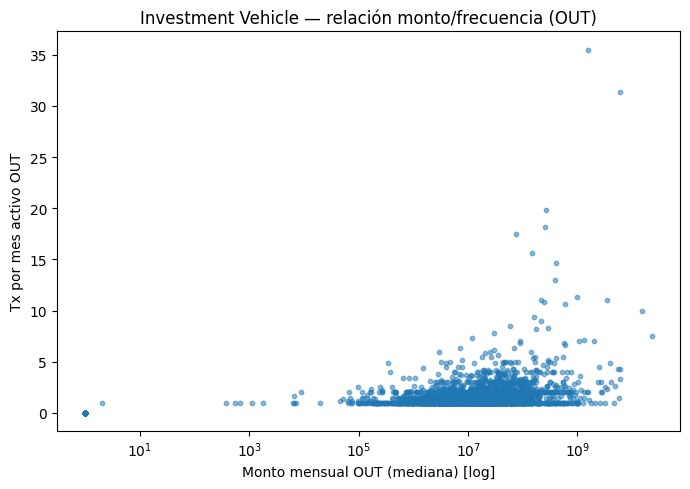

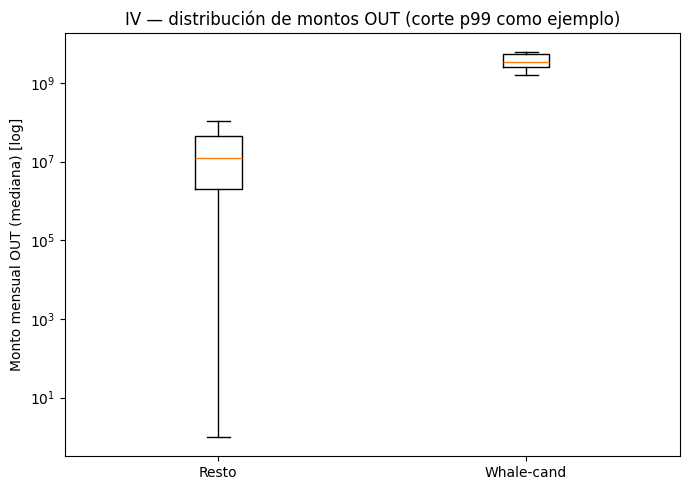

In [6]:
# Scatter OUT: monto mensual (mediana) vs frecuencia
plt.figure(figsize=(7,5))
x = feat_iv["median_monthly_out"].clip(lower=1)  # evita log(0)
y = feat_iv["tx_per_active_month_out"]
plt.scatter(x, y, s=10, alpha=0.5)
plt.xscale("log")
plt.xlabel("Monto mensual OUT (mediana) [log]")
plt.ylabel("Tx por mes activo OUT")
plt.title("Investment Vehicle — relación monto/frecuencia (OUT)")
plt.tight_layout(); plt.show()

# Boxplots por dirección (si quieres separar por 'whale-candidate' marca rápido con un umbral)
# Usa el p99 como ejemplo visual
thr = np.nanpercentile(feat_iv["median_monthly_out"], 99)
labels = np.where(feat_iv["median_monthly_out"]>=thr, "Whale-cand","Resto")
data = [feat_iv.loc[labels=="Resto","median_monthly_out"].clip(lower=1),
        feat_iv.loc[labels=="Whale-cand","median_monthly_out"].clip(lower=1)]
plt.figure(figsize=(7,5))
plt.boxplot(data, showfliers=False)
plt.yscale("log")
plt.xticks([1,2], ["Resto","Whale-cand"])
plt.ylabel("Monto mensual OUT (mediana) [log]")
plt.title("IV — distribución de montos OUT (corte p99 como ejemplo)")
plt.tight_layout(); plt.show()


In [16]:
# === Variables candidatas (ajústalas si tu inspección sugiere otras)
cols = [
    "log_median_monthly_out",  # intensidad OUT
    "tx_per_active_month_out", # frecuencia OUT
    "log_median_ticket_out",   # tamaño típico de ticket OUT
    "log_median_monthly_in",   # intensidad IN
    "tx_per_active_month_in"   # frecuencia IN
]
# crea logs si faltan
for c, src in [("log_median_monthly_out","median_monthly_out"),
               ("log_median_monthly_in","median_monthly_in"),
               ("log_median_ticket_out","median_ticket_out"),
               ("log_median_ticket_in","median_ticket_in")]:
    if c not in feat_iv.columns and src in feat_iv.columns:
        feat_iv[c] = np.log1p(pd.to_numeric(feat_iv[src], errors="coerce").fillna(0))

X = feat_iv[cols].fillna(0).to_numpy()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

best = {"k":None, "sil":-np.inf, "labels":None}
for k in [1,2]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labs) if len(np.unique(labs))>1 else -np.inf
    if sil > best["sil"]:
        best = {"k":k, "sil":sil, "labels":labs}

print(f"Mejor K por silhouette: {best['k']} (sil={best['sil']:.3f})")
if best["labels"] is not None:
    feat_iv["cluster_km"] = best["labels"]
    seg_sum = (feat_iv.groupby("cluster_km")
                      .agg(clientes=("customer_id","nunique"),
                           med_m_out=("median_monthly_out","median"),
                           med_txm_out=("tx_per_active_month_out","median"),
                           med_ticket_out=("median_ticket_out","median"),
                           share=("customer_id", lambda s: 100*s.nunique()/len(feat_iv)))
                      .sort_values("med_m_out"))
    display(seg_sum.style.format({"clientes":"{:,.0f}","med_m_out":"{:,.0f}","med_ticket_out":"{:,.0f}","share":"{:,.2f}"}))


Mejor K por silhouette: 2 (sil=0.624)


,clientes,med_m_out,med_txm_out,med_ticket_out,share
cluster_km,,,,,
1,289,0,0.000000,0,11.66
0,"2,189","16,827,719",1.333333,"10,000,000",88.34


Ver Whales y si conviene KMeans